In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

np.random.seed(1)
%matplotlib inline 
plt.style.use('ggplot')

data = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')
movies = movies.set_index('movieId')[['title','genres']]

In [2]:
data.count()
print data.userId.nunique(), 'users'
print data.movieId.nunique(), 'movies'
print len(data), 'ratings' 
print 100 * (float(len(data)))/ ( data.userId.nunique() * data.movieId.nunique()), '% of possible ratings'

668 users
10325 movies
105339 ratings
1.52729408012 % of possible ratings


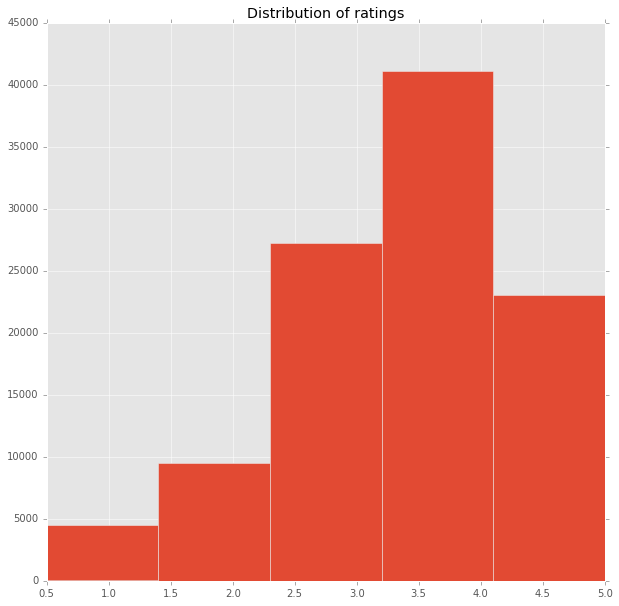

In [3]:
# Ratings distribution
fig = plt.figure(figsize=(10, 10))
ax = plt.hist(data.rating.values, bins=5)
plt.title("Distribution of ratings")

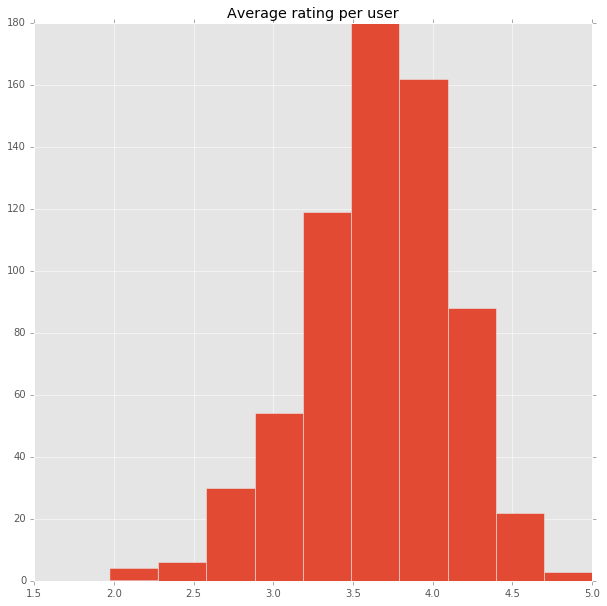

In [7]:
# Average rating per user
fig = plt.figure(figsize=(10,10))
ax = plt.hist(data.groupby('userId').rating.mean().values, bins =10)
plt.title("Average rating per user")

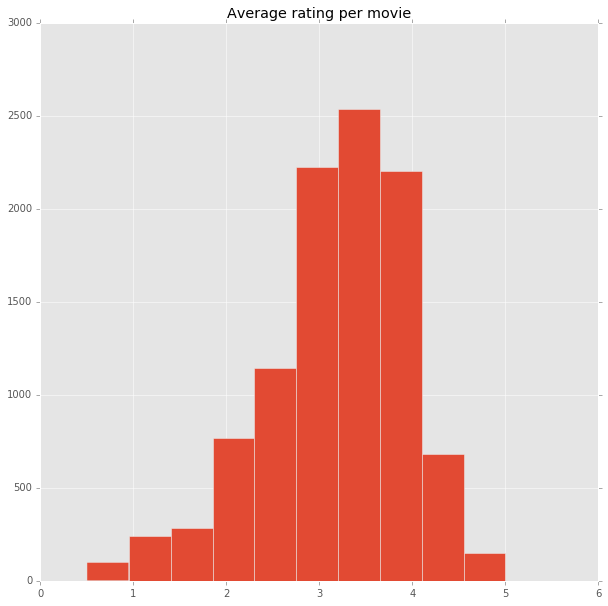

In [8]:
# Average rating per movie
fig = plt.figure(figsize=(10,10))
ax = plt.hist(data.groupby('movieId').rating.mean().values, bins =10)
plt.title("Average rating per movie")

In [9]:
#Top movies找热门的电影
average_movie_rating = data.groupby('movieId').mean()
topMovies = average_movie_rating.sort_values('rating', ascending=False).head(10)
pd.concat([movies.loc[topMovies.index.values],
          average_movie_rating.loc[topMovies.index.values].rating], axis=1)

,title,genres,rating
movieId,,,
465,Heaven & Earth (1993),Action|Drama|War,5.0
111387,Palo Alto (2013),Drama,5.0
1757,Fallen Angels (Duo luo tian shi) (1995),Drama|Romance,5.0
5003,"Nine Lives of Fritz the Cat, The (1974)",Animation,5.0
5007,Topkapi (1964),Adventure|Comedy|Thriller,5.0
5037,"Long Gray Line, The (1955)",Drama,5.0
5042,Forbidden Zone (1980),Musical|Sci-Fi,5.0
91007,I Want to Be a Soldier (2011),Drama,5.0
5056,"Enigma of Kaspar Hauser, The (a.k.a. Mystery o...",Crime|Drama,5.0


In [10]:
#Robust top movies 健壮性更好的热门电影，为rating加点权重
# Lets weight the average rating by the square root of number of ratings
topMovies = data.groupby('movieId').apply(lambda x: len(x)**0.5* x.mean()).sort_values(
    'rating', ascending=False).head(10)
pd.concat([movies.loc[topMovies.index.values],
          average_movie_rating.loc[topMovies.index.values].rating], axis=1)

,title,genres,rating
movieId,,,
318,"Shawshank Redemption, The (1994)",Crime|Drama,4.454545
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.160000
356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.138264
593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.194828
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.188645
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.264368
527,Schindler's List (1993),Drama|War,4.296371
50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.328947
110,Braveheart (1995),Action|Drama|War,4.108871


In [12]:
#争议比较大的电影 ，用std来衡量
controversial_movies = data.groupby('movieId').apply(lambda x: len(x)**0.25 * x.std()).sort_values(
    'rating', ascending=False).head(10)
pd.concat([movies.loc[topMovies.index.values],
          average_movie_rating.loc[topMovies.index.values].rating], axis=1)

,title,genres,rating
movieId,,,
318,"Shawshank Redemption, The (1994)",Crime|Drama,4.454545
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.160000
356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.138264
593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.194828
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.188645
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.264368
527,Schindler's List (1993),Drama|War,4.296371
50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.328947
110,Braveheart (1995),Action|Drama|War,4.108871


#隐因子模型 - Discover hidden attributes of the items and each user's preference for these attributes.
This is known as learning "embeddings" for users and items
加入Bias项，并且用GD来求解theta
However we can speed this up alot by using one random training every iteration. Without going into too much detail, the gradient of a random training is, on average, the same as the gradient on the whole training set. This means we can go, in theory, thousands of times faster!

In [13]:
#  Split the data into training and testing sets
ratings = data[['userId', 'movieId', 'rating']].values
# Shuffle training examples so that movies and users are evenly distributed
np.random.shuffle(ratings)

#axis=0 沿列
n_users, n_items, _ = ratings.max(axis=0) + 1
n = len(ratings)

split_ratios = [0, 0.75, 0.85, 1]
#0~0.75是训练集， 0.75~0.85是validation集， 0.85~1是test集
train_ratings, valid_ratings, test_ratings = [ratings[int(n*lo):int(n*up)] for (lo, up) in zip(split_ratios[:-1], split_ratios[1:])]

#Implements code for
- Initializing embeddings and biases
- Saving and loading parameters
- Predicting given user-item pairs
- Update the parameters to decrease the error

In [14]:
gradients = ["dL_db", "dL_dbu", "dL_dbv", "dL_dU", "dL_dV"]
class Model(object):
    def __init__(self, latent_factors_size, L2_bias=0, L2_emb = 0):
        self.model_parameters = []
        self.gradients = []
        for (name, value) in self.initialize_parameters(latent_factors_size):
            setattr(self, name, value)
            self.gradients.append("dL_d%s" % name)
            self.model_parameters.append(name)
    
    # Random embedding generation from normal distribution, given a size and variance
    def initialize_parameters(self, latent_factors_size=100, std=0.05):
        U = np.random.normal(0, std, size=(n_users + 1, latent_factors_size))
        V = np.random.normal(0., std, size=(n_items + 1, latent_factors_size))
        u = np.zeros(n_users + 1)
        v = np.zeros(n_items + 1)
        return zip( ("b", "u", "v", "U", "V"), (0, u, v, U, V) )
    
    # Used to save parameters during the optimization
    def save_parameters(self):
        return [(name, np.copy(getattr(self, name))) for name in self.model_parameters]
    
    # Used to reload the best parameters once the optimization is finished
    def load_parameters(self, parameters):
        for (name, value) in parameters:
            setattr(self, name, value)
            
    # Sum of the biases and dot product of the embeddings，预测得分
    def predict(self, user_ids, item_ids):
        user_ids = user_ids.astype('int')
        item_ids = item_ids.astype('int')
        return sum([self.b, 
                    self.u[user_ids], 
                    self.v[item_ids], 
                    (self.U[user_ids] * self.V[item_ids]).sum(axis=-1)])
    
    
    # Compute the gradients of the biases and embeddings, given the user-item
    def compute_gradient(self, user_ids, item_ids, ratings):
        predicted_ratings = self.predict(user_ids, item_ids)
        residual = ratings - predicted_ratings

        # biases
        dL_db = -2 * residual
        dL_dbu = -2 * residual
        dL_dbv = -2 * residual

        # embeddings
        eu = self.U[user_ids]
        ev = self.V[item_ids]

        dL_dU = -2 * residual * ev
        dL_dV = -2 * residual * eu

        # Regularization
        l2 = 0.1
        dl2eu_dU = l2 * 2*eu
        dl2ev_dV = l2 * 2*ev
        dl2bu_dbu = l2 * 2*self.u[user_ids]
        dl2bv_dbv = l2 * 2*self.v[item_ids]
        
        dL_dbu = dL_dbu + dl2bu_dbu
        dL_dbv = dL_dbv + dl2bv_dbv
        dL_dU = dL_dU + dl2eu_dU
        dL_dV = dL_dV + dl2ev_dV
        
        # eval蚕食是个字符串，可以将字符串做表达式来计算
        return dict([(g, eval(g)) for g in gradients])
    
    # Perform a gradient descent step
    def update_parameters(self, user, item, rating, learning_rate = 0.005):
        gradients = self.compute_gradient(user, item, rating)
        self.b = self.b - learning_rate * gradients['dL_db']
        self.u[user] = self.u[user] - learning_rate * gradients['dL_dbu']
        self.v[item] = self.v[item] - learning_rate * gradients['dL_dbv']
        self.U[user] = self.U[user] - learning_rate * gradients['dL_dU']
        self.V[item] = self.V[item] - learning_rate * gradients['dL_dV']

In [15]:
# Some useful utilitary functions

#Generate a random number
def sample_random_training_index():
    return np.random.randint(0, len(train_ratings))

# Compute root mean squared error between x and y，j均方根误差
def compute_rmse(x, y):
    return ((x - y)**2).mean()**0.5

# utilitary functions for getting the train/valid/test
def get_rmse(ratings):
    return compute_rmse(model.predict(*ratings.T[:2]), ratings.T[2])

def get_trainset_rmse():
    return get_rmse(train_ratings)

def get_validset_rmse():
    return get_rmse(valid_ratings)

def get_testset_rmse():
    return get_rmse(test_ratings)

#Initialization of the model and optimization

*The gradient descent optimization, Additional notes concerning optimization:
- We will measure performance on the validation set. Optimization will stop when we no - - longer improve on the validation, after a certain number of iterations (patience).
- We will save the error on the training, validation and test set every 10000 iterations.
- Whenever we see the best validation error up to now, we will save the model parameters.

In [17]:
model = Model(latent_factors_size=100)
model.b = train_ratings[:,2].mean()

sgd_iteration_count = 0
best_validation_rmse = 9999
patience = 0
update_frequency = 10000

train_errors = []
valid_errors = []
test_errors = []
best_parameters = None


start_time = time.time()
while True:
    try:
        if sgd_iteration_count % update_frequency == 0:
            train_set_rmse = get_trainset_rmse()
            valid_set_rmse = get_validset_rmse()
            test_set_rmse = get_testset_rmse()
            
            train_errors.append(train_set_rmse)
            valid_errors.append(valid_set_rmse)
            test_errors.append(test_set_rmse)
            
            print 'Iteration:      ', sgd_iteration_count
            print 'Validation RMSE:', valid_set_rmse

            if valid_set_rmse < best_validation_rmse:
                print 'Test RMSE      :', test_set_rmse
                print 'Best validation error up to now !'
                patience = 0
                best_validation_rmse = valid_set_rmse
                best_parameters = model.save_parameters()
            else:
                patience += 1
                if patience >= 20:
                    print 'Exceed patience for optimization, stopping!'
                    break
            print
        training_idx = sample_random_training_index() # SGD,随机生成部分然后去更新参数
        user, item, rating = train_ratings[training_idx]
        model.update_parameters(user, item, rating) 
        sgd_iteration_count += 1
    except KeyboardInterrupt:
        print 'Stopped Optimization'
        print 'Current valid set performance=%s' % compute_rmse(model.predict(*valid_ratings.T[:2]), valid_ratings[:,2])
        print 'Current test set performance=%s' % compute_rmse(model.predict(*test_ratings.T[:2]), test_ratings[:,2])
        break
        
model.load_parameters(best_parameters)
stop_time = time.time()

print 'Optimization time : ', (stop_time - start_time)/60., 'minutes'

C:\Python27\lib\site-packages\ipython-3.1.0-py2.7.egg\IPython\kernel\__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Python27\lib\site-packages\ipython-3.1.0-py2.7.egg\IPython\kernel\__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Python27\lib\site-packages\ipython-3.1.0-py2.7.egg\IPython\kernel\__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Python27\lib\site-packages\ipython-3.1.0-py2.7.egg\IPython\kernel\__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Python27\lib\site-packages\ipython-3.1.0-py2.7.egg\IPython\kernel\__main__.py:49: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Iteration:       0
Validation RMSE: 1.0366757045
Test RMSE      : 1.04147953909
Best validation error up to now !

Iteration:       10000
Validation RMSE: 0.973904340058
Test RMSE      : 0.984506406402
Best validation error up to now !

Iteration:       20000
Validation RMSE: 0.947228243882
Test RMSE      : 0.954012170557
Best validation error up to now !

Iteration:       30000
Validation RMSE: 0.938583921043
Test RMSE      : 0.942496155199
Best validation error up to now !

Iteration:       40000
Validation RMSE: 0.925486272939
Test RMSE      : 0.931404326463
Best validation error up to now !

Iteration:       50000
Validation RMSE: 0.917359551994
Test RMSE      : 0.925394552403
Best validation error up to now !

Iteration:       60000
Validation RMSE: 0.918136437861

Iteration:       70000
Validation RMSE: 0.909143695323
Test RMSE      : 0.916406893728
Best validation error up to now !

Iteration:       80000
Validation RMSE: 0.90761423041
Test RMSE      : 0.917099062899
Best valida

C:\Python27\lib\site-packages\ipython-3.1.0-py2.7.egg\IPython\kernel\__main__.py:50: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Python27\lib\site-packages\ipython-3.1.0-py2.7.egg\IPython\kernel\__main__.py:59: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Python27\lib\site-packages\ipython-3.1.0-py2.7.egg\IPython\kernel\__main__.py:60: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Python27\lib\site-packages\ipython-3.1.0-py2.7.egg\IPython\kernel\__main__.py:74: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Python27\lib\site-packages\ipython-3.1.0-py2.7.egg\IPython\kernel\__main__.py:75: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Py

来来来，来看看优化问题，Lets first try to answer some of these questions by looking at the so-called learning curve 

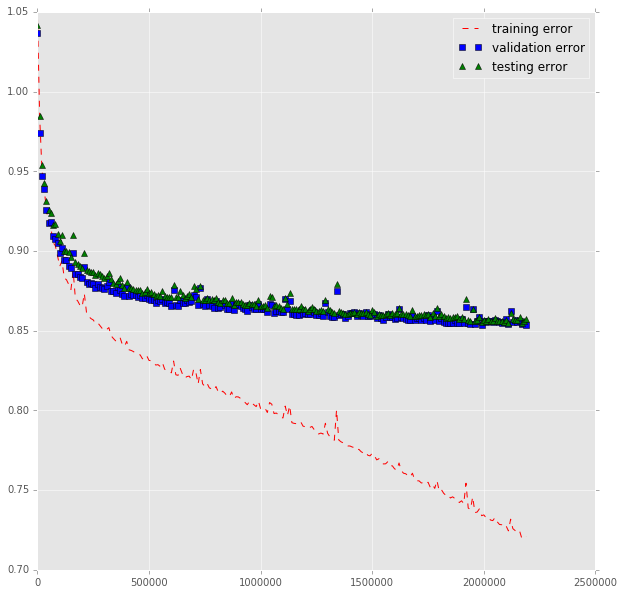

In [18]:
x = update_frequency * np.arange(len(train_errors))
fig = plt.figure(num = None, figsize = (10,10), dpi = 500)
plt.plot(x, train_errors, 'r--', x, valid_errors, 'bs', x, test_errors, 'g^')
plt.legend(['training error', 'validation error', 'testing error'])

上图可知，过拟合了
- Bigger embedding size can lead to more overfitting.
- Smaller size will overfit less, but may perform more poorly on the test set. The best is somewhere in between...

There are also many other things we can do to improve the performance and "generalization":
- Regularization : forcing embeddings to be smaller, so that its harder to overfit. - - -Different coefficients for user/item bias and embedding.
- Learning rate reduction : reducing the learning rate in the later stages of training can help.
- Implicit feedback : use who rated what information, without the rating value
- Tuning all the hyperparameters of the model (learning rate, embedding size, regularization, ...)

#Evaluation!

In [22]:
test_predictions = model.predict(*test_ratings.T[:2])
test_df = pd.DataFrame({'userId': test_ratings[:, 0],
                        'movieId': test_ratings[:, 1],
                        'rating': test_ratings[:, 2],
                        'prediction': test_predictions})
test_df.head(5)

,movieId,prediction,rating,userId
0,63481.0,3.163674,3.5,475.0
1,1259.0,4.448640,4.5,519.0
2,593.0,4.273729,5.0,326.0
3,54775.0,2.469914,1.5,668.0
4,3752.0,2.801175,1.0,468.0


#Standard error metrics for global performance of test set

In [23]:
print 'Root Mean Squared Error\t\t', ((test_df.rating - test_df.prediction)**2).mean()**0.5
print 'Mean Absolute Error\t\t', (test_df.rating - test_df.prediction).abs().mean()
print 'Mean Absolute Percentile Error\t', 100*((test_df.rating - test_df.prediction).abs() / test_df.rating).mean(), '%'

Root Mean Squared Error		0.855405930478
Mean Absolute Error		0.662308878882
Mean Absolute Percentile Error	28.4270050674 %


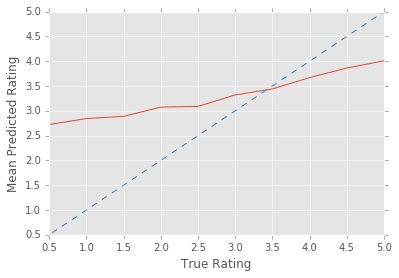

In [24]:
plt.plot(*test_df.groupby('rating').prediction.mean().reset_index().values.T)
plt.plot(np.arange(0, 6), np.arange(0, 6), '--')
plt.xlim([0.5, 5])
plt.ylim([0.5, 5])
plt.xlabel('True Rating')
plt.ylabel('Mean Predicted Rating')
# the model is a bit more conservative, this is normal

#Top-k metrics - precision @ top k across users

In [25]:
best_predicted_rating_per_user = test_df.groupby('userId').apply(
    lambda x: x.sort_values('prediction', ascending=False).head(1).rating)
best_rating_per_user = test_df.groupby('userId').apply(
    lambda x: x.sort_values('rating', ascending=False).head(1).rating)

mean_rating_per_user = test_df.groupby('userId').rating.mean()

In [26]:
# Best rating per user - Best possible performance
print 'Best rating per user\t\t', best_rating_per_user.mean()
# Best predicted rating per user
print 'Best predicted rating per user\t', best_predicted_rating_per_user.mean()
# Random or average performance - Used as baseline
print 'Best mean rating per user\t', mean_rating_per_user.mean()

Best rating per user		4.7263868066
Best predicted rating per user	4.15067466267
Best mean rating per user	3.6592404732


In [27]:
# Precision across users
def precision(x, y):
     return float(len((set(x) & set(y)))) / len(y)

test_df.groupby('userId').apply(lambda x: precision(x.sort_values('rating').tail(3).movieId, 
                                                    x.sort_values('prediction').tail(3).movieId)).mean()

0.47976011994002998

But the most important is... business validation!
One way of looking at embeddings is comparing them together

In [28]:
movies_embeddings = dict([(i, model.V[i]) for i in movies.index.values])

def compute_cosine_similarity(movieId):
    movie_embedding = movies_embeddings[movieId]
    movie_embedding_norm = (movie_embedding**2).sum()**0.5
    similarity = dict([(movie, ((movie_embedding*emb).sum()) / (((emb**2).sum()**0.5) * movie_embedding_norm))
                              for (movie, emb) in movies_embeddings.iteritems()])
    return  similarity

def compute_euclidian_similarity(movieId):
    movie_embedding = movies_embeddings[movieId]
    similarity = dict([(movie, -((movie_embedding-emb)**2).sum()**0.5)
                              for (movie, emb) in movies_embeddings.iteritems()])
    return  similarity

In [29]:
movies[movies.title.str.startswith('Catch Me')]
# movieId = 5952 # lord of the rings
movieId = 79132 # inception
# movieId = 1 # toy story

sorted_movies = sorted(compute_cosine_similarity(movieId).items(), key = lambda x:x[1])
# sorted_movies = sorted(compute_euclidian_similarity(movieId).items(), key = lambda x:x[1])

print 'Closest'
for i in range(1, 16):
    id, sim = sorted_movies[-i]
    print i, movies.loc[id].title, '\t', movies.loc[id].genres, sim
    print

print 'Farthest'
for i in range(15,-1,-1):
    id, sim = sorted_movies[i]
    print i, movies.loc[id].title
    print '\t', movies.loc[id].genres, sim
    print

Closest
1 Inception (2010) 	Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX 1.0

2 Catch Me If You Can (2002) 	Crime|Drama 0.391316594241

3 Living Daylights, The (1987) 	Action|Adventure|Thriller 0.365266721221

4 Nil By Mouth (1997) 	Drama 0.362223855436

5 Knockaround Guys (2002) 	Action|Comedy|Crime 0.352808674223

6 Man Who Would Be King, The (1975) 	Adventure|Drama 0.342463238584

7 Deceiver (1997) 	Crime|Drama|Thriller 0.342407651211

8 Harsh Times (2006) 	Action|Crime|Drama 0.337952813013

9 Star Trek (2009) 	Action|Adventure|Sci-Fi|IMAX 0.335322489229

10 Bourne Identity, The (2002) 	Action|Mystery|Thriller 0.330113799537

11 Revolution OS (2001) 	Documentary 0.321986433751

12 Avatar (2009) 	Action|Adventure|Sci-Fi|IMAX 0.321657485666

13 Gladiator (2000) 	Action|Adventure|Drama 0.319123376632

14 We're No Angels (1955) 	Comedy|Crime|Drama 0.314733702942

15 Green Mile, The (1999) 	Crime|Drama 0.312096623021

Farthest
15 Great Escape, The (1963)
	Action|Adventure|Drama|War -0